## In this Series, I want to show the source code for a fully pipeline to train and make predictions. The implementation is subject to comments from Hau Nguyen, which you can see [here](https://www.kaggle.com/competitions/learning-equality-curriculum-recommendations/discussion/381509).

## The complete architecture for this process is described as follows

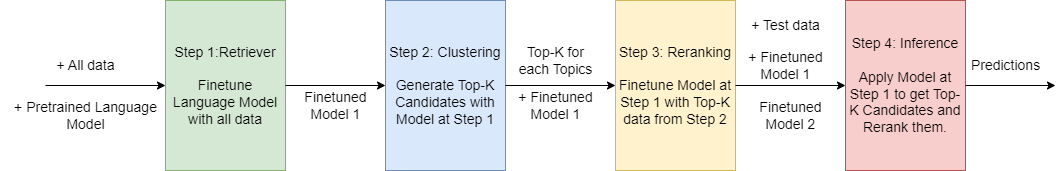

Reference: As a basis for my work, let me use the following these source code:

* Step 1: https://www.kaggle.com/code/andtaichi/finetunig-sentencetransformer by Taichi

* Step 2: https://www.kaggle.com/code/ragnar123/lecr-unsupervised-train-set-public by Martin 

* Step 3: https://www.kaggle.com/code/ragnar123/lecr-xlm-roberta-base-baseline by Martin

* Step 4: https://www.kaggle.com/code/ragnar123/lecr-inference-p by Martin

<b> Please upvote if you like these above notebooks, they really helped me a lot. Thank you so much! </b>







In [ ]:
!pip -qqq install sentence-transformers
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, models, InputExample, losses
from datasets import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold


In [ ]:
DATA_PATH = "/kaggle/input/learning-equality-curriculum-recommendations/"
topics = pd.read_csv(DATA_PATH + "topics.csv")
content = pd.read_csv(DATA_PATH + "content.csv")
correlations = pd.read_csv(DATA_PATH + "correlations.csv")
correlations.shape

In [ ]:
def cv_split(train, n_folds, seed):
    kfold = KFold(n_splits = n_folds, shuffle = True, random_state = seed)
    for num, (train_index, val_index) in enumerate(kfold.split(train)):
        train.loc[val_index, 'fold'] = int(num)
    train['fold'] = train['fold'].astype(int)
    return train

In [ ]:
kfolds = cv_split(correlations, 5, 42)
correlations = kfolds[kfolds.fold != 0]
correlations

### Note: I only use 4/5 folds for finetuning, the 0's fold will use for validation at the next step. So you need to save the kfolds variable to a '.csv' file for the next steps.

In [ ]:
topics.rename(columns=lambda x: "topic_" + x, inplace=True)
content.rename(columns=lambda x: "content_" + x, inplace=True)

In [ ]:
correlations["content_id"] = correlations["content_ids"].str.split(" ")
corr = correlations.explode("content_id").drop(columns=["content_ids"])
corr

In [ ]:
corr = corr.merge(topics, how="left", on="topic_id")
corr = corr.merge(content, how="left", on="content_id")
corr.head()

In [ ]:
corr["set"] = corr[["topic_title", "content_title"]].values.tolist()
train_df = pd.DataFrame(corr["set"])

In [ ]:
dataset = Dataset.from_pandas(train_df)

In [ ]:
dataset

In [ ]:
train_examples = []
train_data = dataset["set"]
n_examples = dataset.num_rows

for i in range(n_examples):
    example = train_data[i]
    if example[0] == None: #remove None
        print(example)
        continue        
    train_examples.append(InputExample(texts=[str(example[0]), str(example[1])]))

In [ ]:
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")


In [ ]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=64)
train_loss = losses.MultipleNegativesRankingLoss(model=model)
# num_epochs = 10
num_epochs = 10
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          save_best_model = True,
          output_path='./paraphrase-multilingual-mpnet-base-v2-exp_fold0_epochs10',
          warmup_steps=warmup_steps)

In [ ]:
# model.save("/kaggle/working/paraphrase-multilingual-mpnet-base-v2-exp")

<a href = 'paraphrase-multilingual-mpnet-base-v2-exp'>Download</a>